#### Import libraries

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,Dropout,Conv2DTranspose,concatenate,BatchNormalization,Activation
import cv2
import PIL
import matplotlib.pyplot as plt
import pandas as pd
from skimage.color import rgb2gray
import shutil
import gc

#### Extract files to local session


In [2]:
#shutil.copyfile(source_folder, destination_folder)

!cp /content/drive/MyDrive/celebaMask.zip /content/

In [3]:
import zipfile

In [4]:
zipfile.ZipFile('/content/celebaMask.zip', 'r').extractall('/content/')

In [2]:
og_folder_path = '/content/Surgical Masked Image'
image_dir = [f for f in os.listdir(og_folder_path) if(os.path.isfile(os.path.join(og_folder_path,f)))]


In [3]:
mask_folder_path = '/content/Image Mask'

In [4]:
len(image_dir)

29625

In [5]:
x=[]
Y=[]
c=0

#### Load Images

In [6]:
for image in image_dir:
    mask_file = image.split('_')[0] + '.jpg'
    if(os.path.isfile(os.path.join(mask_folder_path,mask_file))):
        img_path = os.path.join(og_folder_path,image)
        mask_path = os.path.join(mask_folder_path,mask_file)
        img = cv2.imread(img_path)
        msk = cv2.imread(mask_path)
        img = img / 255.0
        msk = msk / 255.0
        img = cv2.resize(img,(128,128))
        msk = cv2.resize(msk,(128,128))
        #print(image)
        x.append(img)
        Y.append(msk)
        c+=1
        if(c%300==0):
            print((c/300)*1,'%\n')

1.0 %

2.0 %

3.0 %

4.0 %

5.0 %

6.0 %

7.0 %

8.0 %

9.0 %

10.0 %

11.0 %

12.0 %

13.0 %

14.0 %

15.0 %

16.0 %

17.0 %

18.0 %

19.0 %

20.0 %

21.0 %

22.0 %

23.0 %

24.0 %

25.0 %

26.0 %

27.0 %

28.0 %

29.0 %

30.0 %

31.0 %

32.0 %

33.0 %

34.0 %

35.0 %

36.0 %

37.0 %

38.0 %

39.0 %

40.0 %

41.0 %

42.0 %

43.0 %

44.0 %

45.0 %

46.0 %

47.0 %

48.0 %

49.0 %

50.0 %

51.0 %

52.0 %

53.0 %

54.0 %

55.0 %

56.0 %

57.0 %

58.0 %

59.0 %

60.0 %

61.0 %

62.0 %

63.0 %

64.0 %

65.0 %

66.0 %

67.0 %

68.0 %

69.0 %

70.0 %

71.0 %

72.0 %

73.0 %

74.0 %

75.0 %

76.0 %

77.0 %

78.0 %

79.0 %

80.0 %

81.0 %

82.0 %

83.0 %

84.0 %

85.0 %

86.0 %

87.0 %

88.0 %

89.0 %

90.0 %

91.0 %

92.0 %

93.0 %

94.0 %

95.0 %

96.0 %

97.0 %

98.0 %



In [7]:
x=np.array(x)

In [8]:
Y=np.array(Y)

In [9]:
len(x)

29625

In [10]:
Yt = np.array([rgb2gray(image) for image in Y])
Yt.shape

(29625, 128, 128)

In [11]:
def convlayer(filter,input):
    c = Conv2D(filter,(3,3),padding='same')(input)
    c= BatchNormalization()(c)
    c= Activation('relu')(c)
    c = Conv2D(filter,(3,3),padding='same')(c)
    c= BatchNormalization()(c)
    c=Activation('relu')(c)
    c = Dropout(0.5)(c)
    return c

In [12]:
def u_netModel(input_shape=(128,128,3)):
    i = Input(shape=input_shape)

    level1 = convlayer(8,i)
    pool1 = MaxPooling2D(pool_size=(2,2))(level1)

    level2 = convlayer(16,pool1)
    pool2 = MaxPooling2D(pool_size=(2,2))(level2)

    level3 = convlayer(32,pool2)
    pool3 = MaxPooling2D(pool_size=(2,2))(level3)

    level4 = convlayer(64,pool3)
    pool4 = MaxPooling2D(pool_size=(2,2))(level4)

    b_neck = convlayer(128,pool4)

    levelUp4 = Conv2DTranspose(64,(2,2),strides=(2,2),padding='same')(b_neck)
    l4concat = concatenate([levelUp4,level4])
    level5 = convlayer(64,l4concat)

    levelUp3 = Conv2DTranspose(32,(2,2),strides=(2,2),padding='same')(level5)
    l3concat = concatenate([levelUp3,level3])
    level6 = convlayer(32,l3concat)

    levelUp2 = Conv2DTranspose(16,(2,2),strides=(2,2),padding='same')(level6)
    l2concat = concatenate([levelUp2,level2])
    level7 = convlayer(16,l2concat)

    levelUp1 = Conv2DTranspose(8,(2,2),strides=(2,2),padding='same')(level7)
    l1concat = concatenate([levelUp1,level1])
    level8 = convlayer(8,l1concat)

    oput =  Conv2D(1,(1,1),activation='sigmoid')(level8)

    model = Model(inputs = i , outputs = oput)

    return model

In [13]:
model = u_netModel()


In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 8)          224       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 8)          32        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 128, 128, 8)          0         ['batch_normalization[0][0

In [15]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [16]:
model.fit(x, Yt, epochs = 1, batch_size = 32)

926/926 [==============================] - 42s 24ms/step - loss: 0.1191 - accuracy: 0.9688


In [17]:
x_Test = []
y_Test = []

In [18]:
for image in image_dir[10000:10010]:
    mask_file = image.split('_')[0] + '.jpg'
    if(os.path.isfile(os.path.join(mask_folder_path,mask_file))):
        img_path = os.path.join(og_folder_path,image)
        mask_path = os.path.join(mask_folder_path,mask_file)
        img = cv2.imread(img_path)
        msk = cv2.imread(mask_path)
        img = img / 255.0
        msk = msk / 255.0
        img = cv2.resize(img,(128,128))
        msk = cv2.resize(msk,(128,128))
        #print(image)
        x_Test.append(img)
        y_Test.append(msk)

In [19]:
x_Test = np.array(x_Test)
y_Test = np.array(y_Test)

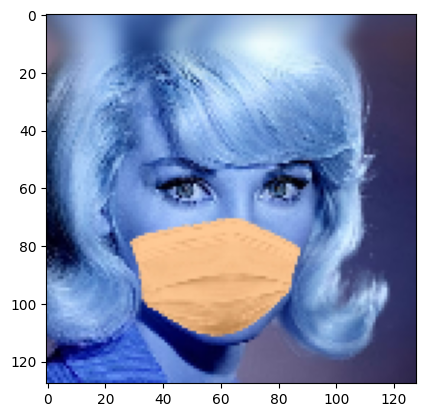

In [20]:
plt.imshow(x_Test[0])

In [21]:
y_pred = model.predict(x_Test)

1/1 [==============================] - 1s 1s/step


In [23]:
y_predRound = np.round(y_pred)

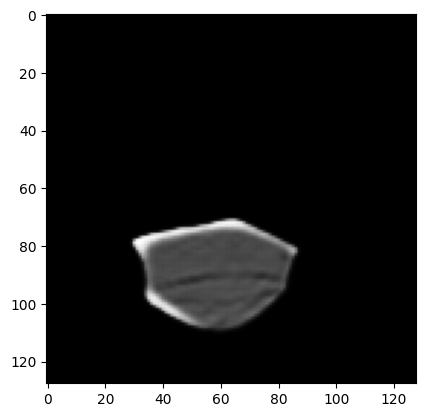

In [25]:
plt.imshow(y_pred[0],cmap="gray")